In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Analysing the data
# a. “UrbanSounds8K” Download the data set. (5,6 GB)
# https://urbansounddataset.weebly.com/urbansound8k.html
# b. extract the .tar file.
# c. read README file to understand the data that we have.

In [ ]:
## Extracting the tar file.
import tarfile
tar_file = tarfile.open('UrbanSound8K.tar.gz')
tar_file.extractall('')
tar_file.close()

In [6]:
import pandas as pd
data = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
pd.set_option("display.max.columns", None)
data.head()
## We've just displayed the first five rows of the DataFrame df using .head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


<AxesSubplot: >

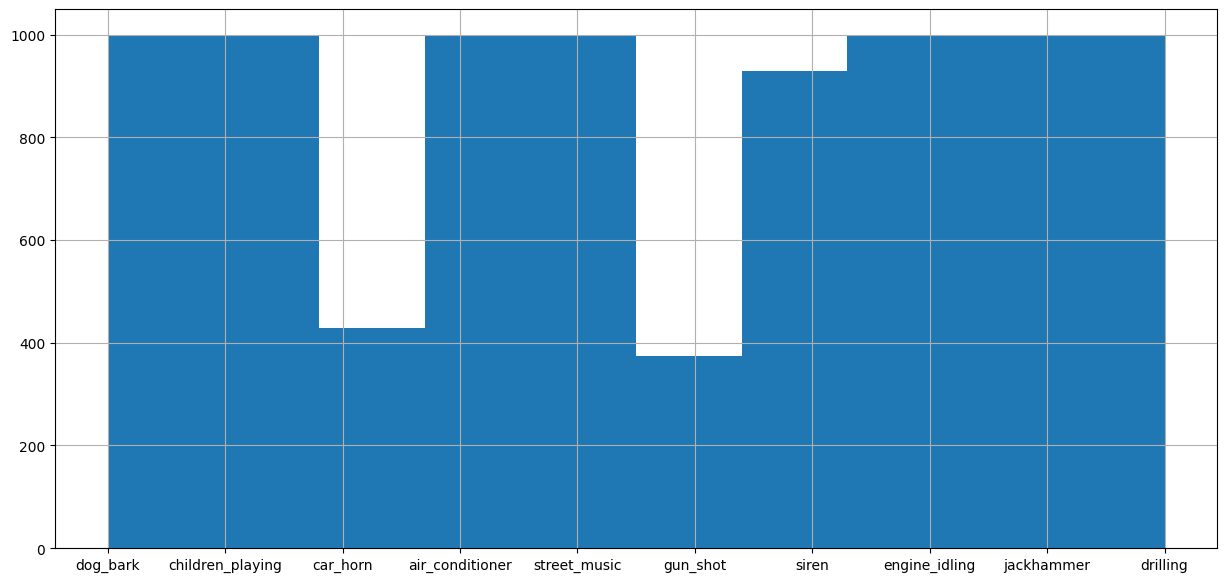

In [16]:
plt.figure(figsize=(15,7))
data["class"].hist()

In [ ]:
#Creating histograms

In [17]:
def create_spectrogram(y):
  spec= librosa.feature.melspectrogram(y=y)
  spec_conv=librosa.amplitude_to_db(spec, ref=np.max)
  return spec_conv

In [52]:
import os
os.mkdir("histograms")
for i in range(10):
  os.mkdir(f"histograms/{i}")

In [53]:
for i in range(1,11):
  folder_directory = f"UrbanSound8K/audio/fold{i}/"
  for wave_sound in os.listdir(folder_directory):
    if wave_sound.endswith(".wav"):
      wave_name = wave_sound.split(".")[0]
      wave_label = wave_sound.split("-")[1]
      sound, sr = librosa.load(folder_directory+wave_sound)
      spectrogram = create_spectrogram(sound)
      librosa.display.specshow(spectrogram,sr=sr)
      plt.savefig("histograms/"+wave_label+"/"+wave_name+".png", pad_inches = 0, bbox_inches ='tight')
      plt.close()

C:\Users\mirza\PycharmProjects\urban_sound_classification\venv\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
C:\Users\mirza\PycharmProjects\urban_sound_classification\venv\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
C:\Users\mirza\PycharmProjects\urban_sound_classification\venv\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)


In [2]:
## Resizing, normalization, gray-scaling and separating images on the images and labels.
import cv2
import random


In [3]:
images = []
labels = []

In [4]:
import os
import numpy as np
for i in range(10):
  image_array=os.listdir(f"histograms/{i}")
  for image in range(len(image_array)):
    img_gray=cv2.imread("histograms/"+str(i)+"/"+image_array[image],0)
    resized_gray = cv2.resize(img_gray, (100, 100), interpolation = cv2.INTER_AREA)
    normalized_gray=resized_gray/255
    images.append(normalized_gray)
    labels.append(i)

dict_ = list(zip(images, labels))
random.seed(42)
random.shuffle(dict_)
images, labels = zip(*dict_)

images=np.array(images)
labels=np.array(labels)

In [ ]:
#Creating the Train, validation, test data sets.

In [5]:
def train_valid_test(images, labels, train_size, valid_size ):
  size=len(images)

  X_train= images[:int(train_size * size)]
  y_train= labels[:int(train_size * size)]

  X_valid= images[int(train_size * size):int((train_size + valid_size) * size)]
  y_valid= labels[int(train_size * size):int((train_size + valid_size) * size)]

  X_test= images[int((train_size + valid_size) * size):]
  y_test= labels[int((train_size + valid_size) * size):]

  return X_train, y_train, X_valid, y_valid, X_test, y_test

In [6]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test(images=images,labels=labels, train_size=0.5,valid_size=0.1)
print(f"X_train shape:{X_train.shape}")
print(f"y_train shape:{y_train.shape}")
print(f"X_valid shape:{X_valid.shape}")
print(f"y_valid shape:{y_valid.shape}")
print(f"y_test shape:{y_test.shape}")
print(f"X_test shape:{X_test.shape}")

X_train shape:(4366, 100, 100)
y_train shape:(4366,)
X_valid shape:(873, 100, 100)
y_valid shape:(873,)
y_test shape:(3493,)
X_test shape:(3493, 100, 100)


In [7]:
import tensorflow as tf

In [10]:
## Creating CNN model.
## input layer
model=tf.keras.Sequential()
## hidden layers
model.add(tf.keras.layers.Conv2D(32,kernel_size=(3,3), strides=(1,1), padding="valid", activation="relu", input_shape=(100,100,1)))
model.add(tf.keras.layers.Conv2D(32,kernel_size=(3,3), strides=(1,1), padding="valid", activation="relu", input_shape=(100,100,1)))

model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Conv2D(128,kernel_size=(3,3), strides=(1,1), padding="valid", activation="relu"))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dropout(0.8))
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dropout(0.8))
#output layer
model.add(tf.keras.layers.Dense(10, activation="softmax"))

## We use sparse categorical crossentropy when our classes are mutually exclusive.
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [11]:
## Training the model with our data set.
results=model.fit(X_train, y_train, batch_size=256, epochs=50, validation_data=(X_valid, y_valid))


Epoch 1/50
18/18 [==============================] - 204s 11s/step - loss: 2.2717 - accuracy: 0.1377 - val_loss: 2.1215 - val_accuracy: 0.2646
Epoch 2/50
18/18 [==============================] - 199s 11s/step - loss: 2.1432 - accuracy: 0.1967 - val_loss: 2.0271 - val_accuracy: 0.2658
Epoch 3/50
18/18 [==============================] - 194s 11s/step - loss: 2.0254 - accuracy: 0.2494 - val_loss: 1.9040 - val_accuracy: 0.3322
Epoch 4/50
18/18 [==============================] - 193s 11s/step - loss: 1.9103 - accuracy: 0.2840 - val_loss: 1.7394 - val_accuracy: 0.4215
Epoch 5/50
18/18 [==============================] - 205s 11s/step - loss: 1.8247 - accuracy: 0.3175 - val_loss: 1.6378 - val_accuracy: 0.4112
Epoch 6/50
18/18 [==============================] - 201s 11s/step - loss: 1.7498 - accuracy: 0.3429 - val_loss: 1.5037 - val_accuracy: 0.4731
Epoch 7/50
18/18 [==============================] - 203s 11s/step - loss: 1.6664 - accuracy: 0.3754 - val_loss: 1.4417 - val_accuracy: 0.5246
Epoch 

In [12]:
## printing the performance matrices, loss and accuracy graphics.
import matplotlib.pyplot as plt

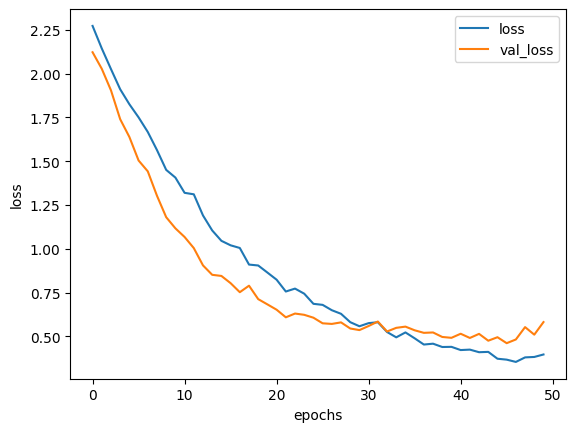

In [13]:
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

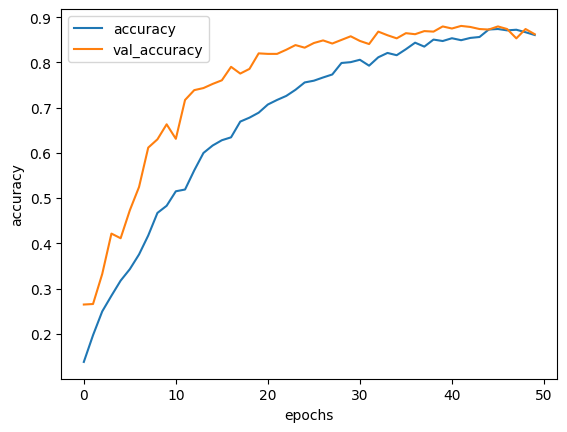

In [14]:
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [15]:
model.evaluate(X_test, y_test)


110/110 [==============================] - 25s 224ms/step - loss: 0.5739 - accuracy: 0.8577


[0.5739330649375916, 0.8577154278755188]

In [16]:
label_to_str={0: "air_conditioner",
              1: "car_horn",
              2: "children_playing",
              3: "dog_bark",
              4: "drilling",
              5: "engine_idling",
              6: "gun_shot",
              7: "jackhammer",
              8: "siren",
              9: "street_music"}

In [17]:
prediction=model.predict(X_test[1].reshape((1, 100, 100, 1)))
prediction_class=prediction.argmax()
prediction_percentage=prediction.max()

print("Actual: "+label_to_str[y_test[3]])
print("Prediction: " + label_to_str[prediction_class])
print("possibility percentage: " + str(prediction_percentage * 100))

1/1 [==============================] - 0s 130ms/step
Actual: dog_bark
Prediction: dog_bark
possibility percentage: 99.89822506904602
